## Problem Statement and Information

**After performing a Campaign for a current product, a large bank would like to `predict which customer would subscribe`**

**`See Dataset description in cell below`**

**The dataset contains information about marketing campaigns that were conducted via phone calls from a Nigerian banking institution to their clients. The purpose of these campaigns is to prompt their clients to subscribe to a specific financial product of the bank (term deposit). After each call was conducted, the client had to inform the institution about their intention of either subscribing to the product (indicating a successful campaign) or not (unsuccessful campaign). The final output of this survey will be a binary result indicating if the client subscribed ('yes') to the product or not ('no')**

The data has been split into two groups: - training set (train.csv) - test set (test.csv) The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each customer

The dataset several rows (instances of calls to clients) and 21 columns (variables) which are describing certain aspects of the call. Please note that there are cases where the same client was contacted multiple times - something that practically doesn't affect the analysis as each call will be considered independent from another even if the client is the same.

**`Content: The predictor variables (features) contained in the dataset can be divided into the following five sections:`**


**1. Variables that describing attributes related directly to the client:**

* age
* job : type of job (e.g. 'admin', 'technician', 'unemployed', etc)
* marital: marital status ('married', 'single', 'divorced', 'unknown')
* education: level of education ('basic.4y', 'high.school', 'basic.6y', 'basic.9y','professional.course',   'unknown','university.degree','illiterate')
* default: if the client has credit in default ('no', 'unknown', 'yes')
* housing: if the client has housing a loan ('no', 'unknown', 'yes')
* loan: if the client has a personal loan ? ('no', 'unknown', 'yes')

**2. Variables related to the last contact of the current campaign:**

* contact: type of communication ('telephone', 'cellular')
* month: month of last contact
* dayofweek: day of last contact
* duration: call duration (in seconds)

**3. Other variables related to the campaign(s):**

* campaign: number of contacts performed during this campaign and for this client
* pdays: number of days passed by after the client was last contacted from a previous campaign
* previous: number of contacts performed before this campaign and for this client
* poutcome: outcome of previous marketing campaign ('nonexistent', 'failure', 'success')

**4. Socioeconomic variables:**

* emp_var_rate: employment variation rate - quarterly indicator
* cons_price_idx: consumer price index - monthly indicator
* cons_conf_idx: consumer confidence index - monthly indicator
* euribor3m: euribor 3 month rate - daily indicator
* nr_employed: number of employees - quarterly indicator

Of course, the dataset also containt the variable subscribed which is the target variable, indicating if the client subscribed to the product ('yes':1) or not ('no':0).

****

## Import Libraries and define required functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report

import itertools
%matplotlib inline
sns.set()

In [2]:
# basically, this function plota a confusion matrix using the prediction values and test values of the target variable
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# read in train, test, sample submission data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis and Pre-processing

In [4]:
# check columns in train dataset
train.columns

Index(['customer_id', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed'],
      dtype='object')

In [5]:
# creating new column 'source' in both train and test dataframes with different values like a key, the column values will be used to seperate them later
train["source"] = 1
test["source"] =0

#concatenate datasets
data = pd.concat([train, test]).reset_index(drop=True)
print(data.shape)
print(train.shape)
print(test.shape)

(41188, 23)
(28831, 23)
(12357, 22)


In [6]:
# check for missing values
data.isna().sum()

customer_id           0
age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
subscribed        12357
source                0
dtype: int64

In [7]:
#data.profile_report()

****

#### Drop Unrequired Columns

In [8]:
data.drop(["customer_id"], axis=1, inplace=True)

In [9]:
#checking for unique values in the categorcal columns, to examine their entries
cat_cols = data.columns[data.dtypes == object]
for col in cat_cols:
    print(col.upper(), "column has", data[col].nunique(), "unique values:\n", data[col].value_counts())

JOB column has 12 unique values:
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
MARITAL column has 4 unique values:
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
EDUCATION column has 8 unique values:
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
DEFAULT column has 3 unique values:
 no         32588
unknown     8597
yes            3
Name: default, dtype: int64
HOUSING column has 3 unique values:
 yes        21576
no         18622
unknown      990
Name: housing, dtype: in

In [10]:
# perform label encoding on concocatenated dataset
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,31,0,1,6,0,0,0,0,2,1,...,999,1,0,-2.97,46.3565,-23.10,1.711,5023.5,0.0,1
1,31,9,2,6,0,0,0,1,6,0,...,999,0,1,-1.77,46.4465,-32.34,2.252,5099.1,0.0,1
2,47,1,1,1,1,2,0,1,6,2,...,999,0,1,1.13,46.9970,-25.48,5.862,5191.0,0.0,1
3,36,7,1,6,0,0,0,0,6,2,...,999,1,0,-1.77,46.4465,-32.34,2.329,5099.1,0.0,1
4,34,0,2,3,0,0,0,0,6,0,...,999,0,1,-1.77,46.4465,-32.34,2.252,5099.1,0.0,1


In [11]:
# using the 'source' column, split the data back into test and train
train_df = data.loc[data["source"] ==1]
test_df = data.loc[data["source"] ==0]

In [12]:
# drop 'source' column in both dfs and 'target variable' in train dataset

test_df.drop(["source", "subscribed"], axis=1, inplace=True)
train_df.drop(["source"], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
# check post-split shape with original data shape
print(data.shape)
print(train_df.shape)
print(test_df.shape)

(41188, 22)
(28831, 21)
(12357, 20)


## Data Split and Model Creation & Training

In [14]:
# split train data into X and y for model_selection and creation
y = train.subscribed
X = train_df.drop(["subscribed"], axis=1)

In [15]:
# split the data into train and test
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 1234)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20181, 20), (20181,), (8650, 20), (8650,))

In [16]:
# select model and evaluation metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

# fit the data to the selected model and predict target variable over X_test data
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f1_score(pred, y_test))

0.4691689008042895


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [55]:
# model evaluation
print(accuracy_score(y_test, pred))
print('\n')
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

0.8889017341040463


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7682
           1       0.50      0.51      0.51       968

    accuracy                           0.89      8650
   macro avg       0.72      0.72      0.72      8650
weighted avg       0.89      0.89      0.89      8650



[[7193  489]
 [ 472  496]]


In [17]:
# select new model, fit data and predict
from sklearn.tree import DecisionTreeClassifier
decisiontreemodel = DecisionTreeClassifier()

decisiontreemodel.fit(X_train, y_train)
pred = decisiontreemodel.predict(X_test)
print(f1_score(pred, y_test))

0.5079365079365079


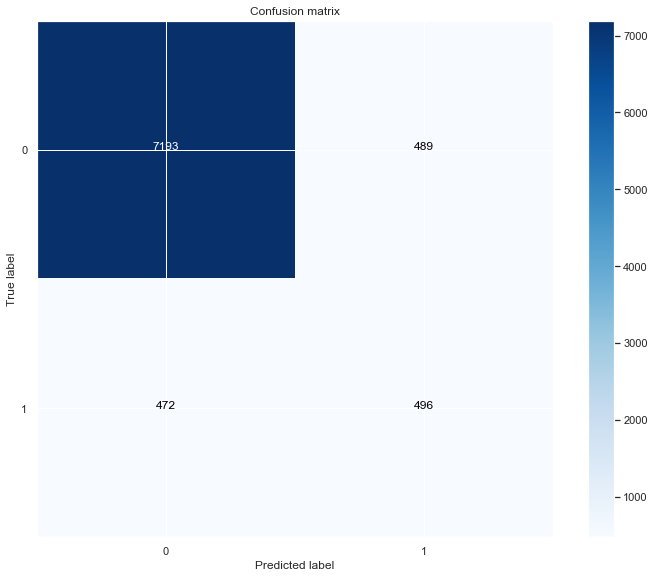

In [18]:
# plot confusion matrix for decision DecisionTree
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [19]:
# export predictions from decision tree model
predictions = decisiontreemodel.predict(test_df)

In [20]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
sub.head()

,customer_id,subscribed
0,customer_id_32884,1
1,customer_id_3169,1
2,customer_id_32206,1
3,customer_id_9403,1
4,customer_id_14020,1


In [22]:
preds = pd.DataFrame({"customer_id": sub["customer_id"],"subscribed":predictions})

In [23]:
#export data to csv 
preds.to_csv("predis.csv", index=False)

# Further Analysis: Standardize Values and Try different Model(s)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [25]:
sc = StandardScaler()

In [26]:
sc.fit(X_train)
X_train_std =sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [27]:
svc = SVC(kernel='linear', C=10.0, random_state = 1)
svc.fit(X_train, y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [28]:
y1_pred = svc.predict(X_test)

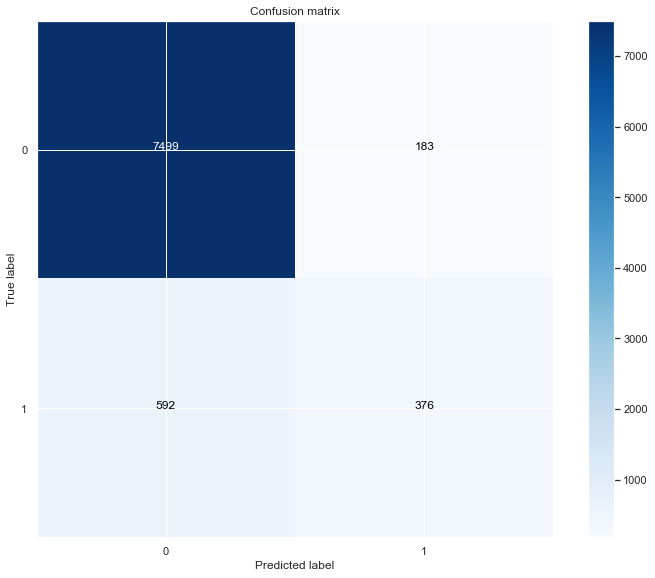

In [29]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,y1_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

# Random Forest 

In [30]:
model2 = RandomForestClassifier()

In [31]:
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
rand_pred = model2.predict(X_test)

In [33]:
rand_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [54]:
print(accuracy_score(y_test, rand_pred))
print('\n')
print(classification_report(y_test, rand_pred))
print('\n')
print(confusion_matrix(y_test, rand_pred))

0.9127167630057803


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7682
           1       0.65      0.47      0.55       968

    accuracy                           0.91      8650
   macro avg       0.79      0.72      0.75      8650
weighted avg       0.90      0.91      0.91      8650



[[7438  244]
 [ 511  457]]


In [34]:
print(f1_score(rand_pred, y_test))

0.5476333133612942


**Note that Random Forest f1_score for the overall predictions in the cell just above is the `highest f1_score`**

So far this is my best score attained using this dataset and approach 

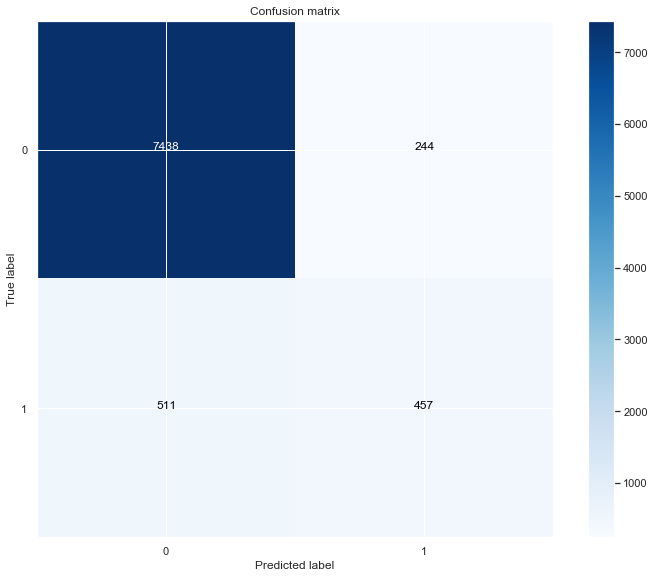

In [35]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,rand_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

**Export Predictions and `Export Predictions for submission`**

In [39]:
test_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
28831,59,9,1,3,0,0,2,0,6,1,6.183333,1,999,1,0,-1.77,46.4465,-32.34,2.301,5099.1
28832,57,11,1,7,1,2,0,1,6,2,4.750000,2,999,0,1,1.13,46.9970,-25.48,5.862,5191.0
28833,35,1,1,2,0,0,0,0,6,0,0.866667,1,999,1,0,-1.77,46.4465,-32.34,2.315,5099.1
28834,38,0,1,3,0,0,0,1,4,0,5.916667,4,999,0,1,1.43,47.2325,-29.26,5.969,5228.1
28835,29,3,1,3,0,2,0,0,3,0,3.150000,2,999,0,1,1.43,46.9590,-29.89,5.965,5228.1


In [40]:
predictions = model2.predict(test_df)

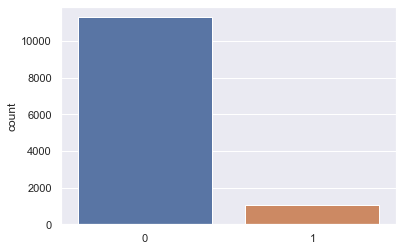

In [41]:
sns.countplot(predictions)

In [43]:
test_df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
41183,48,7,1,3,0,2,0,0,3,1,3.016667,2,999,0,1,1.43,46.9590,-29.89,5.962,5228.1
41184,40,7,0,3,1,2,0,0,0,3,10.333333,1,2,1,2,-1.77,46.5375,-32.97,2.455,5099.1
41185,28,1,2,3,0,0,2,1,3,1,4.183333,2,999,0,1,1.43,46.9590,-29.89,5.964,5228.1
41186,53,9,0,5,0,0,2,0,1,0,0.833333,3,999,0,1,1.43,46.7220,-25.27,5.968,5228.1
41187,47,9,1,6,0,0,0,0,7,4,3.683333,2,999,1,0,-0.07,46.6000,-29.40,5.122,5195.8


In [44]:
test['customer_id']

0        customer_id_32884
1         customer_id_3169
2        customer_id_32206
3         customer_id_9403
4        customer_id_14020
               ...        
12352    customer_id_15908
12353    customer_id_28222
12354    customer_id_14194
12355    customer_id_19764
12356    customer_id_26052
Name: customer_id, Length: 12357, dtype: object

In [46]:
sub.head()

,customer_id,subscribed
0,customer_id_32884,1
1,customer_id_3169,1
2,customer_id_32206,1
3,customer_id_9403,1
4,customer_id_14020,1


In [47]:
predictions.shape

(12357,)

In [49]:
sub.shape

(12357, 2)

In [50]:
preds = pd.DataFrame({"customer_id": sub["customer_id"],"subscribed": predictions})

In [52]:
preds.head()

,customer_id,subscribed
0,customer_id_32884,0
1,customer_id_3169,0
2,customer_id_32206,0
3,customer_id_9403,0
4,customer_id_14020,0


In [53]:
preds.to_csv("aisub2.csv", index=False)

****

**Export Training Set to be used in Collab for Further Analysis in order to try `Keras Models`**

In [56]:
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,31,0,1,6,0,0,0,0,2,1,...,3,999,1,0,-2.97,46.3565,-23.10,1.711,5023.5,0.0
1,31,9,2,6,0,0,0,1,6,0,...,4,999,0,1,-1.77,46.4465,-32.34,2.252,5099.1,0.0
2,47,1,1,1,1,2,0,1,6,2,...,2,999,0,1,1.13,46.9970,-25.48,5.862,5191.0,0.0
3,36,7,1,6,0,0,0,0,6,2,...,1,999,1,0,-1.77,46.4465,-32.34,2.329,5099.1,0.0
4,34,0,2,3,0,0,0,0,6,0,...,9,999,0,1,-1.77,46.4465,-32.34,2.252,5099.1,0.0


In [57]:
print(train_df.shape, test_df.shape, data.shape, )

(28831, 21) (12357, 20) (41188, 22)


In [58]:
train_df.to_csv('df.csv', index=False)

**Export Test Set to be used in Collab for Further Analysis in order to try `Keras Models`**

In [59]:
test_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
28831,59,9,1,3,0,0,2,0,6,1,6.183333,1,999,1,0,-1.77,46.4465,-32.34,2.301,5099.1
28832,57,11,1,7,1,2,0,1,6,2,4.750000,2,999,0,1,1.13,46.9970,-25.48,5.862,5191.0
28833,35,1,1,2,0,0,0,0,6,0,0.866667,1,999,1,0,-1.77,46.4465,-32.34,2.315,5099.1
28834,38,0,1,3,0,0,0,1,4,0,5.916667,4,999,0,1,1.43,47.2325,-29.26,5.969,5228.1
28835,29,3,1,3,0,2,0,0,3,0,3.150000,2,999,0,1,1.43,46.9590,-29.89,5.965,5228.1


In [60]:
test_df.to_csv('df_test.csv', index=False)